# Modelling Customer Lifetime Value for Non-Contractual Business.

In [90]:
#importing all the required libraries
%pylab inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go

np.random.seed(42)
import random
random.seed(42)
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
from datetime import datetime
import gc
import itertools

import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import *
from lifetimes.utils import *
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

Populating the interactive namespace from numpy and matplotlib


In [72]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [73]:
# loading the datasets
customers_db = pd.read_csv("input/olist_customers_dataset.csv")
order_items_db = pd.read_csv("input/olist_order_items_dataset.csv")
order_payments_db = pd.read_csv("input/olist_order_payments_dataset.csv")
orders_db = pd.read_csv("input/olist_orders_dataset.csv")
products_db = pd.read_csv("input/olist_products_dataset.csv")
sellers_db = pd.read_csv("input/olist_sellers_dataset.csv")

In [74]:
# displaying data shape and column headings
dataset = {
    'Customers': customers_db,
    'Order Items': order_items_db,
    'Payments': order_payments_db,
    'Orders': orders_db,
    'Products': products_db,
    'Sellers': sellers_db
}

for x, y in dataset.items():
    print(f'{x}', (list(y.shape)))
    print(f'{x}', f'{list(y.columns)}')
    print('\n')

Customers [99441, 5]
Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


Order Items [112650, 7]
Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']


Payments [103886, 5]
Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']


Orders [99441, 8]
Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']


Products [32951, 9]
Products ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


Sellers [3095, 4]
Sellers ['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']




In [75]:
cols = ['customer_id', 'order_id', 'order_purchase_timestamp']
orders_db = orders_db[cols]
orders_db = orders_db.set_index('customer_id')
orders_db.drop_duplicates(inplace=True)
orders_db["order_purchase_timestamp"] = pd.to_datetime(orders_db["order_purchase_timestamp"])
cols = ['customer_id', 'customer_unique_id']
customers_db = customers_db[cols]
customers_db = customers_db.set_index('customer_id')

# concatinating Datasets
purchases_db = pd.concat([orders_db,customers_db], axis=1, join='inner')
purchases_db.reset_index(inplace=True)
purchases_db.head(5)
cols = ['customer_unique_id', 'order_id','order_purchase_timestamp']
purchases_db = purchases_db[cols]

In [76]:
# aggregate cost of items
costs = order_items_db.groupby("order_id")["price"].sum()

# adding columns and conversion to datetime
purchases_db['order_purchase_timestamp'] = pd.to_datetime(purchases_db['order_purchase_timestamp'])
purchases_db['order_date'] = purchases_db.order_purchase_timestamp.dt.date
purchases_db['order_date'] = pd.to_datetime(purchases_db['order_date'])
cols = ['customer_unique_id', 'order_id', 'order_date']
purchases_db = purchases_db[cols]
purchases_db.head(5)

,customer_unique_id,order_id,order_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13


In [77]:
purchases_db = purchases_db.merge(costs.to_frame("total_cost").reset_index(), on='order_id')
purchases_db.columns = ["customer_id", "order_id", "order_date", "total_cost"]

### Active Customers

In [78]:
#creating monthly active customers dataframe by counting unique Customer IDs
customer_order_db = pd.concat([orders_db,customers_db], axis=1, join='inner')
customer_order_db = customer_order_db.merge(order_payments_db, on='order_id')
customer_order_db['order_purchase_month'] = customer_order_db.order_purchase_timestamp.apply(lambda x: x.month)
customer_order_db['order_purchase_year'] = customer_order_db.order_purchase_timestamp.apply(lambda x: x.year)
customer_order_db['month_year'] = customer_order_db['order_purchase_year'].astype(str)\
+ '-' + customer_order_db['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
customer_order_db['month_y'] = customer_order_db['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

customer_order_db.head(5)
monthly_active_users = customer_order_db.groupby('month_year')['customer_unique_id'].nunique().reset_index()

In [79]:
configure_plotly_browser_state()
trace0 = go.Bar(
    x=monthly_active_users["month_year"].values,
    y=monthly_active_users["customer_unique_id"].values,
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Active Customers',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### Comparing Existing v/s New Customer 

In [80]:
customer_order_db.head(5)

,order_id,order_purchase_timestamp,customer_unique_id,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_month,order_purchase_year,month_year,month_y
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,1,credit_card,1,18.12,10,2017,2017-10,201710
1,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3,voucher,1,2.00,10,2017,2017-10,201710
2,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2,voucher,1,18.59,10,2017,2017-10,201710
3,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,1,boleto,1,141.46,7,2018,2018-07,201807
4,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,1,credit_card,3,179.12,8,2018,2018-08,201808


In [81]:
#create a dataframe contaning CustomerID and first purchase date
df_min_purchase = customer_order_db.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
df_min_purchase.columns = ['customer_unique_id','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

#merge first purchase date column to our main dataframe (tx_uk)
customer_order_db = pd.merge(customer_order_db, df_min_purchase, on='customer_unique_id')
#create a column called User Type and assign Existing 
#if User's First Purchase Year Month before the selected Invoice Year Month
customer_order_db['usertype'] = 'New'
customer_order_db.loc[customer_order_db['month_y']>customer_order_db['minpurchasedate'],'usertype'] = 'Existing'

#calculate the Revenue per month for each user type
df_user_type_revenue = customer_order_db.groupby(['month_y','usertype', 'month_year'])['payment_value'].sum().reset_index()

df_user_type_revenue

,month_y,usertype,month_year,payment_value
0,201609,New,2016-09,252.24
1,201610,New,2016-10,59090.48
2,201612,New,2016-12,19.62
3,201701,Existing,2017-01,19.62
4,201701,New,2017-01,138468.42
5,201702,Existing,2017-02,170.83
6,201702,New,2017-02,291737.18
7,201703,Existing,2017-03,650.82
8,201703,New,2017-03,449212.78
9,201704,Existing,2017-04,2566.60


In [82]:
fig = px.line(df_user_type_revenue, x="month_year", y="payment_value", color='usertype')
fig.show()

### Customer Retention Rate

In [83]:
#create retention matrix with crosstab using purchase
df_retention = pd.crosstab(customer_order_db['customer_unique_id'], customer_order_db['month_y']).reset_index()
df_retention.head()

#creating an array of dictionary which keeps Retained & Total User count for each month
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['month_y'] = int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

df_retention

,RetainedUserCount,TotalUserCount,month_y,RetentionRate
0,0,1,201612,0.000000
1,1,850,201701,0.001176
2,3,1886,201702,0.001591
3,4,2837,201703,0.001410
4,14,2571,201704,0.005445
5,15,3944,201705,0.003803
6,20,3436,201706,0.005821
7,21,4317,201707,0.004864
8,46,4550,201708,0.010110
9,41,4516,201709,0.009079


## Data Explore

Frequency - Represents the number of repeat purchases the customer has made.

T - Represents the age of the customer in whatever time units chosen (daily, in our dataset).

Recency - Represents the age of the customer when they made their most recent purchases.

In [84]:
data = summary_data_from_transaction_data(purchases_db, 'customer_id', 'order_date', 
                                          monetary_value_col='total_cost', 
                                          observation_period_end='2018-09-28')
data.head()

,frequency,recency,T,monetary_value
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,141.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,144.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,567.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,351.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,318.0,0.0


count    95420.000000
mean         0.024198
std          0.178936
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: frequency, dtype: float64
0.9781492349612241


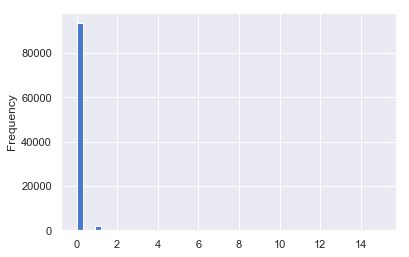

In [85]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

## Frequency/Recency Analysis Using the BG/NBD Model

In [86]:
bgf = BetaGeoFitter()
bgf.fit(data["frequency"],
        data["recency"], 
        data["T"], 
        iterative_fitting = 3, 
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.082623
         Iterations: 56
         Function evaluations: 59
         Gradient evaluations: 59


<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.43, alpha: 54.27, b: 0.37, r: 0.01>

### Visualizing our frequency/recency matrix

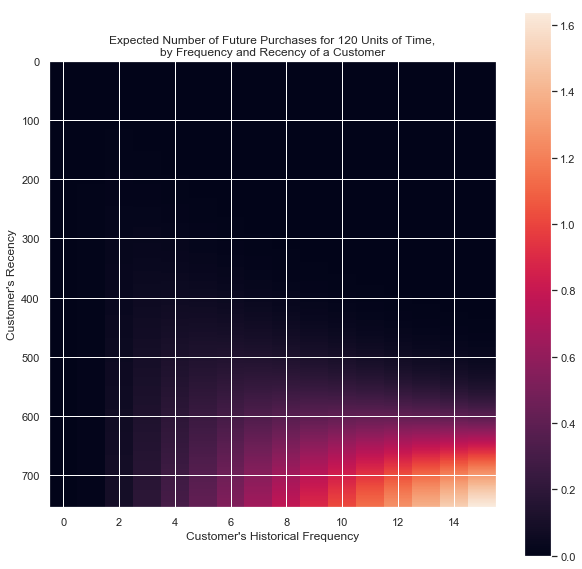

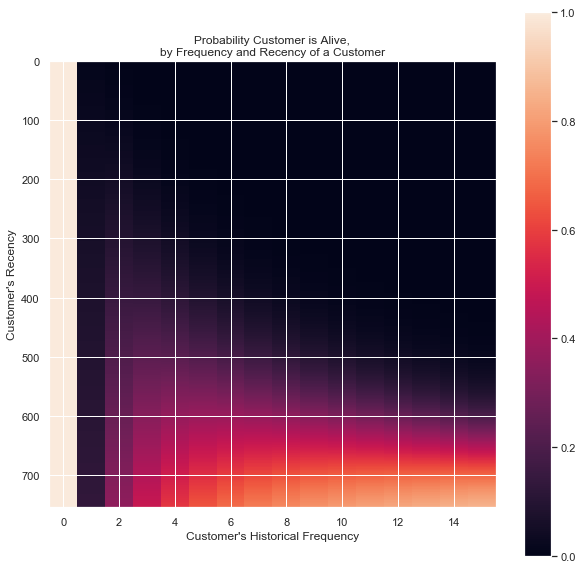

In [87]:
plt.figure(figsize=(10, 10))
plot_frequency_recency_matrix(bgf, T=120);

plt.figure(figsize=(10, 10))
plot_probability_alive_matrix(bgf);

In [88]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
customer_id,,,,,
e0836a97eaae86ac4adc26fbb334a527,2.0,62.0,94.0,24.245,0.003468
6469f99c1f9dfae7733b25662e7f1782,5.0,282.0,374.0,116.840,0.004070
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,280.0,123.400,0.005272
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,454.0,97.552,0.005458
8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,501.0,47.642,0.017932


### Assessing model fit

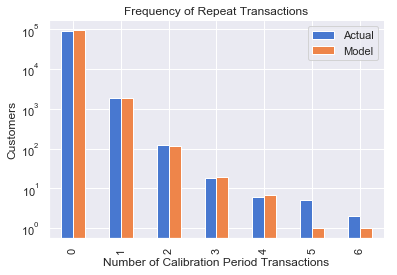

In [91]:
ax = plot_period_transactions(bgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

In [93]:
cal_hold = calibration_and_holdout_data(purchases_db, 
                                        customer_id_col = 'customer_id',
                                        datetime_col = 'order_date',
                                        freq = 'D',
                                        calibration_period_end = '2018-06-30',
                                        observation_period_end = '2018-09-28',
                                        monetary_value_col = 'total_cost' )
print(cal_hold.head())

                                  frequency_cal  recency_cal  T_cal  \
customer_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2            0.0          0.0   51.0   
0000b849f77a49e4a4ce2b2a4ca5be3f            0.0          0.0   54.0   
0000f46a3911fa3c0805444483337064            0.0          0.0  477.0   
0000f6ccb0745a6a4b88665a16c9f078            0.0          0.0  261.0   
0004aac84e0df4da2b147fca70cf8255            0.0          0.0  228.0   

                                  monetary_value_cal  frequency_holdout  \
customer_id                                                               
0000366f3b9a7992bf8c76cfdf3221e2                 0.0                0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                 0.0                0.0   
0000f46a3911fa3c0805444483337064                 0.0                0.0   
0000f6ccb0745a6a4b88665a16c9f078                 0.0                0.0   
0004aac84e0df4da2b147fca70cf8255                 0.0

In [94]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter()
bgf.fit(cal_hold["frequency_cal"], 
        cal_hold["recency_cal"], 
        cal_hold["T_cal"], 
        iterative_fitting = 3, 
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.078588
         Iterations: 58
         Function evaluations: 61
         Gradient evaluations: 61


<lifetimes.BetaGeoFitter: fitted with 83128 subjects, a: 1.65, alpha: 71.15, b: 0.30, r: 0.02>

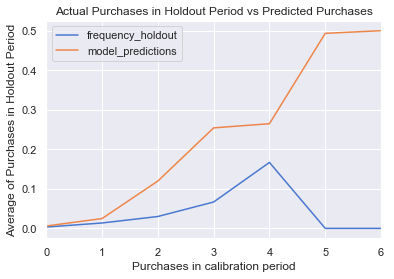

In [95]:
bgf.fit(cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, cal_hold)

## Customer probability histories
We look at our best customer’s transactions history and see the probability of being alive

In [97]:
t = 120
predicted_purchases = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                               cal_hold['frequency_cal'], 
                                                                               cal_hold['recency_cal'],
                                                                               cal_hold['T_cal'])
predicted_purchases.sort_values().tail(4)

customer_id
fe81bb32c243a86b2f86fbf053fe6140    0.765942
6469f99c1f9dfae7733b25662e7f1782    0.983676
ca77025e7201e3b30c44b472ff346268    1.117771
8d50f5eadf50201ccdcedfb9e2ac8455    1.488107
dtype: float64

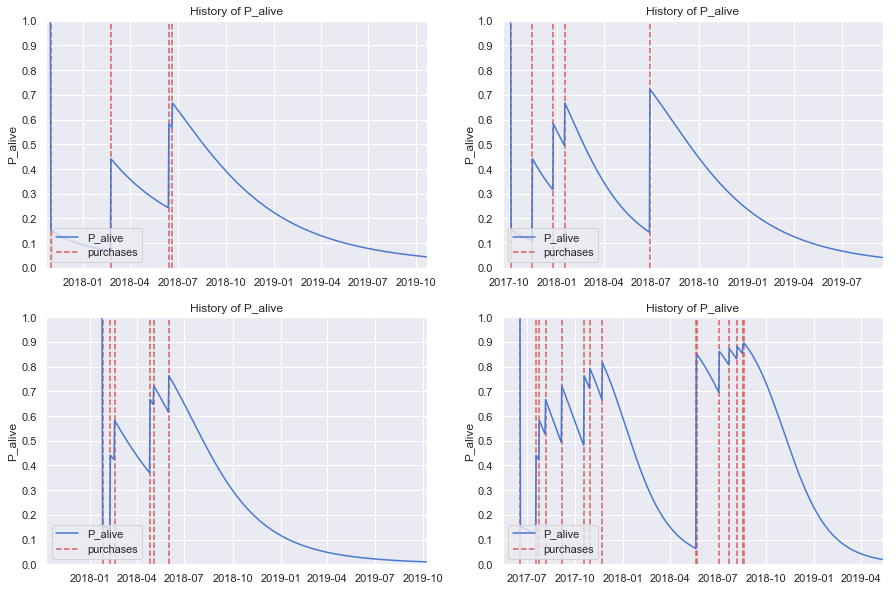

In [98]:
fig = plt.figure(figsize=(15, 10))
t = max(purchases_db.order_date - min(purchases_db.order_date))
for idx, customer_id in enumerate(predicted_purchases.sort_values().tail(4).index, 1):
    days_since_birth = (t).days
    sp_trans = purchases_db.loc[purchases_db['customer_id'] == customer_id]
    
    plot_history_alive(bgf, days_since_birth, sp_trans, 'order_date', ax=fig.add_subplot(2, 2, idx))

## Estimating customer lifetime value using gamma-gamma model of monetary value

In [99]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))
print(returning_customers_summary[["frequency", "monetary_value"]].corr())

                                  frequency  recency      T  monetary_value  \
customer_id                                                                   
004288347e5e88a27ded2bb23747066c        1.0    171.0  428.0           87.90   
004b45ec5c64187465168251cd1c9c2f        1.0    267.0  392.0           27.00   
0058f300f57d7b93c477a131a59b36c3        1.0     31.0  221.0           72.58   
00a39521eb40f7012db50455bf083460        1.0     11.0  128.0           11.55   
011575986092c30523ecb71ff10cb473        1.0     60.0  223.0           63.90   

                                  predicted_purchases  
customer_id                                            
004288347e5e88a27ded2bb23747066c             0.000138  
004b45ec5c64187465168251cd1c9c2f             0.000223  
0058f300f57d7b93c477a131a59b36c3             0.000163  
00a39521eb40f7012db50455bf083460             0.000282  
011575986092c30523ecb71ff10cb473             0.000213  
2085
                frequency  monetary_value
frequen

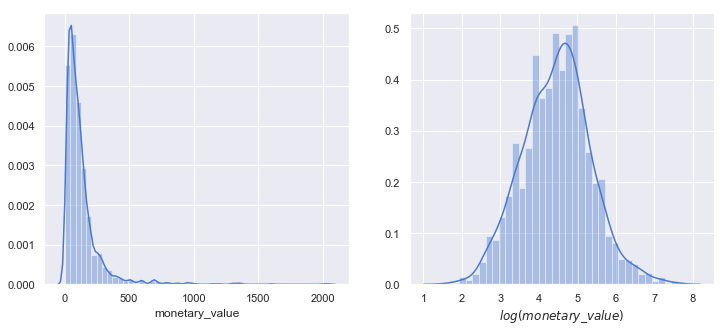

In [100]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))
sns.distplot(returning_customers_summary["monetary_value"], ax=axes[0], )
sns.distplot(np.log(returning_customers_summary["monetary_value"] + 1), ax=axes[1], axlabel='$log(monetary\_value)$')

In [101]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter()
ggf.fit(returning_customers_summary["frequency"], 
       returning_customers_summary["monetary_value"], verbose=True)

Optimization terminated successfully.
         Current function value: 5.753528
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27


<lifetimes.GammaGammaFitter: fitted with 2085 subjects, p: 2.81, q: 2.94, v: 88.94>

In [102]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(5))

customer_id
0000366f3b9a7992bf8c76cfdf3221e2    129.181956
0000b849f77a49e4a4ce2b2a4ca5be3f    129.181956
0000f46a3911fa3c0805444483337064    129.181956
0000f6ccb0745a6a4b88665a16c9f078    129.181956
0004aac84e0df4da2b147fca70cf8255    129.181956
dtype: float64


After applying Gamma-Gamma model, now we can estimate average transaction value for each customer